# Librerías

In [2]:
from datetime import date
import time
import sys
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from astropy.table import Table
from astroquery.sdss import SDSS
from matplotlib import pyplot as plt

import astropy.units as u
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from astropy.coordinates import SkyCoord

# Extract Data

In [3]:
query_sdss = """SELECT TOP 150000
        s.specobjid, s.ra, s.dec, g.h_alpha_flux, g.h_beta_flux, 
        g.sii_6717_flux, g.sii_6731_flux, g.nii_6548_flux, g.nii_6584_flux,
        g.oi_6300_flux, g.oii_3726_flux, g.oii_3729_flux, g.oiii_5007_flux,
        g.h_alpha_eqw, p.u,p.g,p.r,p.i,p.z,s.z as redshift,ID.bptclass
                
        FROM SpecObjAll AS s
        JOIN galSpecExtra AS ID ON ID.specObjID = s.specObjID
        JOIN galSpecLine AS g ON g.specObjID = s.specObjID
        JOIN PhotoObj AS p ON p.objID = s.bestObjID
                
        WHERE 
        s.z <=1
        AND s.class IN ('QSO','GALAXY')
        AND g.h_alpha_flux >0 AND g.h_beta_flux >0
        AND g.sii_6717_flux >0 AND g.sii_6731_flux >0 
        AND g.nii_6548_flux >0 AND g.nii_6584_flux >0
        AND g.oii_3726_flux >0 AND g.oii_3729_flux >0
        AND g.oi_6300_flux >0 AND g.oiii_5007_flux >0         
        AND p.u >0 AND p.g >0 AND p.r >0 AND p.i >0 AND p.z >0   
        --ORDER BY redshift DESC
        """

data_sdss = SDSS.query_sql(query_sdss)
t=Table(data_sdss)
sdss_df=t.to_pandas()

# Prepare Data

In [4]:
sdss_df['ra'] = sdss_df['ra'].astype(str) 
sdss_df['dec'] = sdss_df['dec'].astype(str) 
sdss_df['Full Name'] = sdss_df[['ra','dec']].agg(' - '.join, axis=1) 
sdss_df = sdss_df.drop_duplicates(subset = ['Full Name']).reset_index(drop=True)
sdss_df

,specobjid,ra,dec,h_alpha_flux,h_beta_flux,sii_6717_flux,sii_6731_flux,nii_6548_flux,nii_6584_flux,oi_6300_flux,...,oiii_5007_flux,h_alpha_eqw,u,g,r,i,z,redshift,bptclass,Full Name
0,299504245504239616,146.51283,-0.84576492,1138.16000,249.537900,193.648000,163.149000,182.943500,551.799700,30.287210,...,91.973940,-38.333920,17.37162,16.17903,15.50150,15.05806,14.78616,0.064921,1,146.51283 - -0.84576492
1,299508644020512768,146.8833,-0.49469887,417.92880,79.063780,49.422900,40.359170,74.879070,225.852600,8.980413,...,33.677190,-14.887030,18.61111,16.85827,15.79716,15.23164,14.82215,0.083766,3,146.8833 - -0.49469887
2,299519914014697472,146.60365,-0.19149282,290.14100,65.580040,32.113320,23.394300,32.063990,96.712390,2.340104,...,11.179900,-21.075860,18.91808,17.66467,16.97991,16.55797,16.32081,0.121521,2,146.60365 - -0.19149282
3,299552624015861760,145.66918,-0.42102498,57.58780,14.059640,18.728760,11.091670,2.562155,7.728051,3.586863,...,24.982670,-9.914010,18.95498,17.82506,17.43953,17.22630,17.11545,0.030347,1,145.66918 - -0.42102498
4,299560046189111296,145.47929,-1.0534252,19.41698,0.118627,4.994998,2.353296,3.376222,10.183460,5.432991,...,12.061760,-0.729967,20.01167,18.03220,17.05094,16.61067,16.26844,0.088422,-1,145.47929 - -1.0534252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132624,946927766111021056,179.95517,4.8617387,116.44540,31.079750,23.831420,17.288200,21.474280,64.771380,6.045217,...,71.526620,-6.724793,18.44067,17.02022,16.42480,16.06015,15.87604,0.076420,4,179.95517 - 4.8617387
132625,946934088302880768,179.64433,4.6511336,92.19975,12.216620,17.556750,14.191220,11.754320,35.453750,3.235921,...,8.855413,-7.595204,20.10372,18.36809,17.43592,16.97110,16.61575,0.134493,2,179.64433 - 4.6511336
132626,946971746576132096,179.14417,5.849597,701.65880,192.623000,133.260500,90.918840,51.129360,154.217900,25.421670,...,259.816500,-63.148370,18.69672,17.76591,17.45605,17.18393,17.08665,0.104751,1,179.14417 - 5.849597
132627,946972021454039040,179.05964,6.1132791,52.15423,6.546834,10.903740,12.604500,13.394670,40.401410,3.092642,...,12.719490,-3.976285,19.13666,17.28001,16.29733,15.73054,15.37100,0.091616,5,179.05964 - 6.1132791


### Ratio Lines 

In [5]:
ejex1=np.log10((sdss_df['nii_6548_flux']+sdss_df['nii_6584_flux'])/sdss_df['h_alpha_flux'])
ejex2=np.log10((sdss_df['sii_6717_flux']+sdss_df['sii_6731_flux'])/sdss_df['h_alpha_flux'])
ejex3=np.log10(sdss_df['oi_6300_flux']/sdss_df['h_alpha_flux'])
ejex4=np.log10((sdss_df['oii_3726_flux']+sdss_df['oii_3729_flux'])/sdss_df['h_alpha_flux'])
ejex5=np.log10((sdss_df['oii_3726_flux']+sdss_df['oii_3729_flux'])/sdss_df['h_beta_flux'])

ejey=np.log10((sdss_df['oiii_5007_flux'])/(sdss_df['h_beta_flux']))
ejey2=np.log10(np.abs(sdss_df['h_alpha_eqw']))

### Features Table

In [6]:
sdss_df['OIII/Hβ']=ejey
sdss_df['NII/Hα']=ejex1
sdss_df['SII/Hα']=ejex2
sdss_df['OI/Hα']=ejex3
sdss_df['OII/Hα']=ejex4
sdss_df['OII/Hβ']=ejex5
sdss_df['W_Hα']=ejey2

#U-B
sdss_df['U']=(sdss_df['u']-0.0682)-(0.0140*(sdss_df['u']-sdss_df['g']-1.2638))
sdss_df['B']=(sdss_df['u']-1.0286)-(0.7981*(sdss_df['u']-sdss_df['g']-1.2638))
sdss_df['U-B']=(sdss_df['U']-sdss_df['B'])

#UGRIZ
sdss_df['u-r']=sdss_df['u']-sdss_df['r']
sdss_df['g-z']=sdss_df['g']-sdss_df['z']

data=sdss_df[['OIII/Hβ','NII/Hα','SII/Hα','OI/Hα','OII/Hα','OII/Hβ','U-B','u-r','g-z','W_Hα']].dropna()
data

,OIII/Hβ,NII/Hα,SII/Hα,OI/Hα,OII/Hα,OII/Hβ,U-B,u-r,g-z,W_Hα
0,-0.433472,-0.190068,-0.503782,-1.574944,-0.558107,0.100960,0.904564,1.87012,1.39287,1.583583
1,-0.370642,-0.142923,-0.667913,-1.667806,-1.083297,-0.360173,1.343856,2.81395,2.03612,1.172808
2,-0.768334,-0.352773,-0.718256,-2.093374,-0.735968,-0.090131,0.952253,1.93817,1.34386,1.323785
3,0.249665,-0.747906,-0.285817,-1.205616,0.177477,0.789833,0.855425,1.51545,0.70961,0.996249
4,2.007229,-0.155932,-0.421995,-0.553143,-0.079927,2.134073,1.521557,2.96073,1.76376,-0.136696
...,...,...,...,...,...,...,...,...,...,...
132624,0.361990,-0.130385,-0.452073,-1.284710,-0.451332,0.122313,1.083229,2.01587,1.14418,0.827679
132625,-0.139742,-0.290713,-0.463014,-1.454732,-0.725775,0.152004,1.330362,2.66780,1.75234,0.880539
132626,0.129959,-0.533637,-0.495530,-1.440922,-0.084387,0.477031,0.699303,1.24067,0.67926,1.800362
132627,0.288438,0.013461,-0.346069,-1.226960,-0.599847,0.301411,1.425254,2.83933,1.90901,0.599478


In [7]:
dataset_test = data.values
dataset_test

array([[-0.43347172, -0.19006774, -0.50378212, ...,  1.87012   ,
         1.39287   ,  1.58358323],
       [-0.37064173, -0.14292313, -0.66791269, ...,  2.81395   ,
         2.03612   ,  1.17280806],
       [-0.76833376, -0.35277289, -0.7182565 , ...,  1.93817   ,
         1.34386   ,  1.32378531],
       ...,
       [ 0.12995859, -0.53363706, -0.49553039, ...,  1.24067   ,
         0.67926   ,  1.80036214],
       [ 0.28843837,  0.01346109, -0.34606942, ...,  2.83933   ,
         1.90901   ,  0.5994775 ],
       [ 0.24267163, -0.73077635, -0.56678362, ...,  1.23445   ,
         0.52442   ,  2.10125168]])

# Data Training

In [8]:
train=pd.read_csv('Base_Training.csv')
train

,OIII/Hβ(T),NII/Hα(T),SII/Hα(T),OI/Hα(T),OII/Hα(T),OII/Hβ(T),U-B(T),u-r(T),g-z(T),W_Hα(T),Class
0,-0.511534,-0.282601,-0.550826,-2.277344,-0.664161,0.067101,1.146483,2.56232,1.92651,0.737114,0
1,0.031058,0.006219,-0.381808,-1.690442,-0.420385,0.225863,1.309905,2.76829,1.91374,0.508915,1
2,-0.291857,-0.075556,-0.314836,-1.097566,-0.633704,0.134805,1.414708,2.70735,1.68751,0.910148,0
3,0.352327,-0.039192,-0.489706,-1.184454,-0.701911,0.007858,0.980975,1.99377,1.38972,1.406762,1
4,-0.262371,-0.322655,-0.395636,-1.236737,-0.382277,0.266697,1.057903,2.09817,1.40212,1.302402,0
...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.717471,-0.345288,-0.669087,-1.708966,-1.109867,-0.430754,1.037461,2.11366,1.47668,1.299626,3
19996,-0.489300,-0.388981,-0.473112,-2.022064,-0.447894,0.161596,1.169904,2.18895,1.37615,1.190096,3
19997,0.055106,-0.546034,-0.535442,-1.536443,-0.210880,0.367051,0.681002,1.25246,0.84499,2.065092,3
19998,-0.247481,-0.377665,-0.488794,-1.581965,-0.356022,0.234276,0.785742,1.50061,0.98178,1.611690,3


In [9]:
from tensorflow.keras.utils import to_categorical
dataset_train = train.values
x_train = dataset_train[:,0:10].astype(float)
y = dataset_train[:,10]
y_train=to_categorical(y)

# Neural Networks

In [35]:
from keras.models import Sequential
from keras.layers import LeakyReLU

model = Sequential()
model.add(Dense(50, input_dim=10, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_normal'))
model.add(Dense(20, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(10, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
hist=model.fit(x_train,y_train, batch_size=50, epochs=100, validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 3s 5ms/step - loss: 0.6697 - accuracy: 0.7254 - val_loss: 0.2380 - val_accuracy: 0.9275
Epoch 2/100
360/360 [==============================] - 2s 5ms/step - loss: 0.3209 - accuracy: 0.8765 - val_loss: 0.1378 - val_accuracy: 0.9575
Epoch 3/100
360/360 [==============================] - 2s 5ms/step - loss: 0.2230 - accuracy: 0.9157 - val_loss: 0.0955 - val_accuracy: 0.9735
Epoch 4/100
360/360 [==============================] - 1s 4ms/step - loss: 0.1781 - accuracy: 0.9328 - val_loss: 0.0694 - val_accuracy: 0.9815
Epoch 5/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1463 - accuracy: 0.9455 - val_loss: 0.0669 - val_accuracy: 0.9805
Epoch 6/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1272 - accuracy: 0.9511 - val_loss: 0.0270 - val_accuracy: 0.9975
Epoch 7/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1117 - accuracy: 0.9591 - val_loss: 0.0690 - val_accuracy: 0.9785

Epoch 58/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0357 - accuracy: 0.9842 - val_loss: 0.0121 - val_accuracy: 0.9970
Epoch 59/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0384 - accuracy: 0.9842 - val_loss: 0.0285 - val_accuracy: 0.9895
Epoch 60/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0338 - accuracy: 0.9857 - val_loss: 0.0535 - val_accuracy: 0.9735
Epoch 61/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0361 - accuracy: 0.9844 - val_loss: 0.0243 - val_accuracy: 0.9920
Epoch 62/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0389 - accuracy: 0.9842 - val_loss: 0.0766 - val_accuracy: 0.9610
Epoch 63/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0424 - accuracy: 0.9826 - val_loss: 0.0360 - val_accuracy: 0.9855
Epoch 64/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0347 - accuracy: 0.9854 - val_loss: 0.0167 - val_accuracy:

In [37]:
x_test = model.predict(dataset_test)
y_test_class = np.argmax(x_test, axis=1)
x_test

4145/4145 [==============================] - 11s 3ms/step


array([[9.9999857e-01, 7.8944333e-13, 1.1208496e-18, 1.4437724e-06],
       [9.9999988e-01, 2.7354714e-11, 7.1293787e-18, 7.5089226e-08],
       [8.8276131e-12, 1.1089288e-28, 5.5570731e-32, 1.0000000e+00],
       ...,
       [7.0713094e-07, 4.0059663e-25, 4.1212397e-19, 9.9999928e-01],
       [3.0787902e-07, 9.9988258e-01, 1.1709883e-04, 1.5955777e-16],
       [5.4603720e-16, 2.5635147e-38, 2.4501057e-27, 1.0000000e+00]],
      dtype=float32)

In [38]:
y_test_class

array([0, 0, 3, ..., 3, 1, 3], dtype=int64)

In [39]:
df_predicciones = pd.DataFrame({'prediccion' : y_test_class})
df_predicciones

,prediccion
0,0
1,0
2,3
3,3
4,2
...,...
132624,2
132625,0
132626,3
132627,1


In [40]:
scores = model.evaluate(x_train, y_train, verbose=0)
print('Precisión del modelo: {}\n Error del modelo: {}'.format(scores[1], 1 - scores[1]))   

Precisión del modelo: 0.9811000227928162
 Error del modelo: 0.018899977207183838


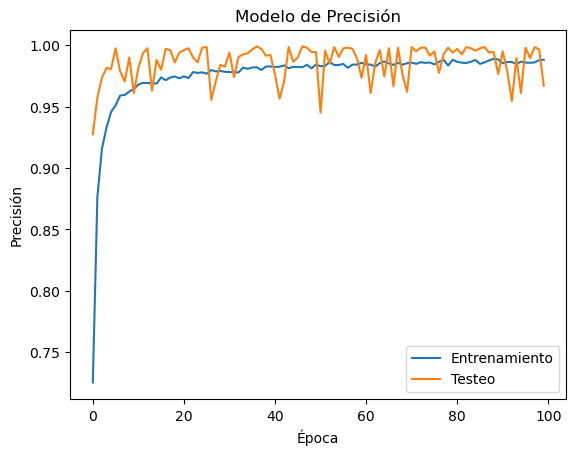

In [41]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Modelo de Precisión')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Testeo'], loc='lower right')
plt.show()

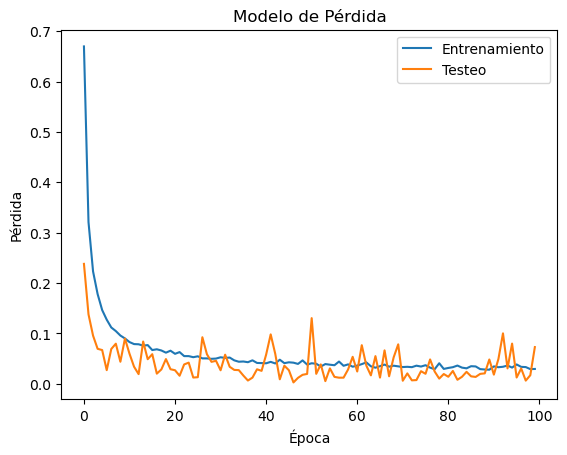

In [42]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Modelo de Pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper right')
plt.show()

In [43]:
column_names = ['OIII/Hβ','NII/Hα','SII/Hα','OI/Hα','OII/Hα','OII/Hβ','U-B','u-r','g-z','W_Hα']
df=pd.DataFrame(dataset_test,columns=column_names)
df['Predicted Class'] = pd.Series(y_test_class)
df

,OIII/Hβ,NII/Hα,SII/Hα,OI/Hα,OII/Hα,OII/Hβ,U-B,u-r,g-z,W_Hα,Predicted Class
0,-0.433472,-0.190068,-0.503782,-1.574944,-0.558107,0.100960,0.904564,1.87012,1.39287,1.583583,0
1,-0.370642,-0.142923,-0.667913,-1.667806,-1.083297,-0.360173,1.343856,2.81395,2.03612,1.172808,0
2,-0.768334,-0.352773,-0.718256,-2.093374,-0.735968,-0.090131,0.952253,1.93817,1.34386,1.323785,3
3,0.249665,-0.747906,-0.285817,-1.205616,0.177477,0.789833,0.855425,1.51545,0.70961,0.996249,3
4,2.007229,-0.155932,-0.421995,-0.553143,-0.079927,2.134073,1.521557,2.96073,1.76376,-0.136696,2
...,...,...,...,...,...,...,...,...,...,...,...
132624,0.361990,-0.130385,-0.452073,-1.284710,-0.451332,0.122313,1.083229,2.01587,1.14418,0.827679,2
132625,-0.139742,-0.290713,-0.463014,-1.454732,-0.725775,0.152004,1.330362,2.66780,1.75234,0.880539,0
132626,0.129959,-0.533637,-0.495530,-1.440922,-0.084387,0.477031,0.699303,1.24067,0.67926,1.800362,3
132627,0.288438,0.013461,-0.346069,-1.226960,-0.599847,0.301411,1.425254,2.83933,1.90901,0.599478,1


In [44]:
comp=df['Predicted Class']==0
lin=df['Predicted Class']==1
sf=df['Predicted Class']==2
sb=df['Predicted Class']==3

## BPT Diagram 

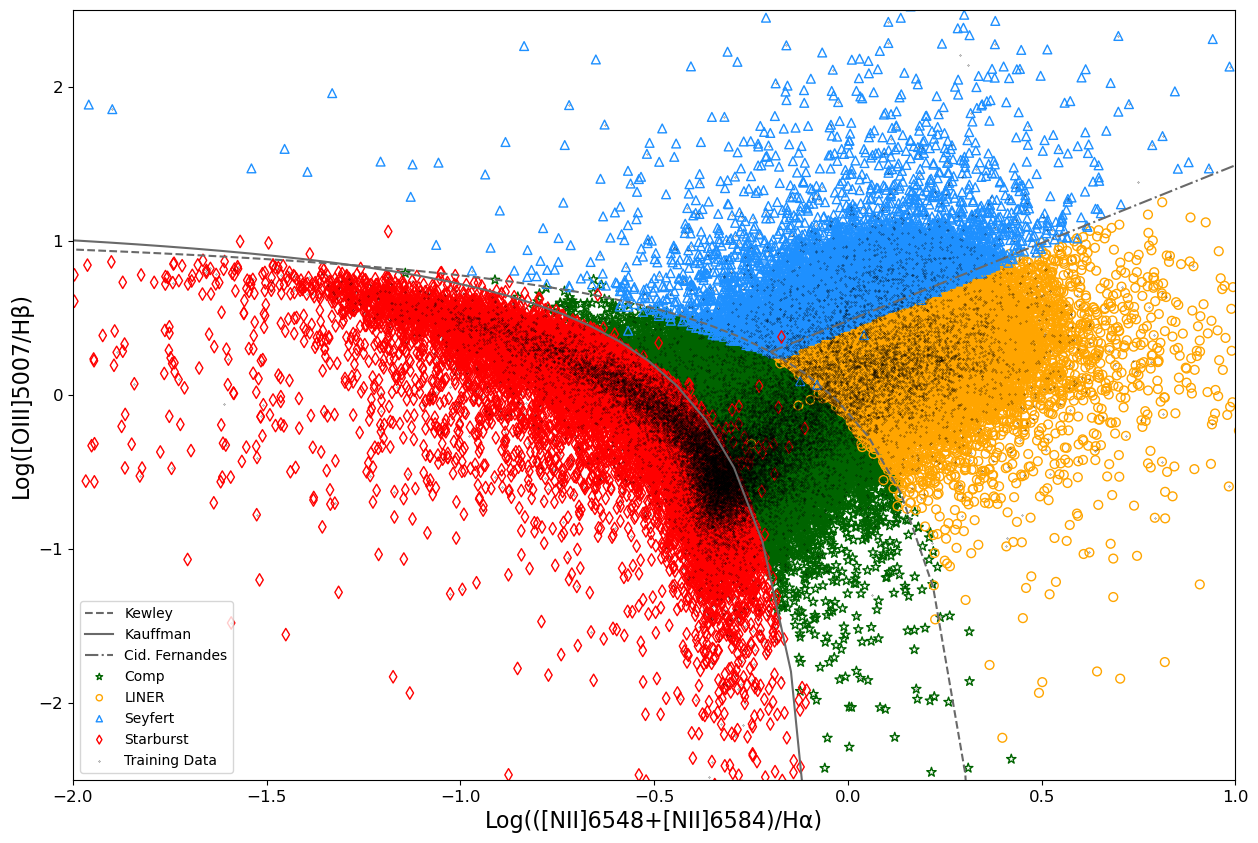

In [45]:
# Kewley
x1 = np.linspace(-3.6,0.469)
y1 = 1.19 + (0.61/(x1-0.47))

#Kauffman
x2 = np.linspace(-3.6,0.0) 
y2 = 1.3 + (0.61/(x2-0.05))

#Cid-Fernandes
x3 = np.linspace(-0.2,4.0) 
y3 = 0.48 +(1.01*x3)

fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(1,1,1)
ax0.plot(x1, y1, '--' , color='dimgray',lw=1.5, label='Kewley') 
ax0.plot(x2, y2, '-' , color='dimgray', lw=1.5, label='Kauffman') 
ax0.plot(x3, y3, '-.' , color='dimgray', lw=1.5, label='Cid. Fernandes') 

ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],comp*50, marker='*',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],lin*40, marker='o',facecolors="none",edgecolors="orange",label='LINER') 
ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],sf*40, marker='^',facecolors="none",edgecolors="dodgerblue",label='Seyfert') 
ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],sb*40, marker='d',facecolors="none",edgecolors="red",label='Starburst') 
ax0.scatter(train['NII/Hα(T)'], train['OIII/Hβ(T)'], c="black", s=0.05,label='Training Data') 

ax0.set_ylim(-2.5,2.5) 
ax0.set_xlim(-2,1) 
ax0.set_xlabel(r'Log(([NII]6548+[NII]6584)/Hα)',fontsize=16) 
ax0.set_ylabel(r'Log([OIII]5007/Hβ)',fontsize=16)
ax0.tick_params(axis='both', which='major', labelsize=12) 
plt.legend()
plt.show()

## WHAN Diagram

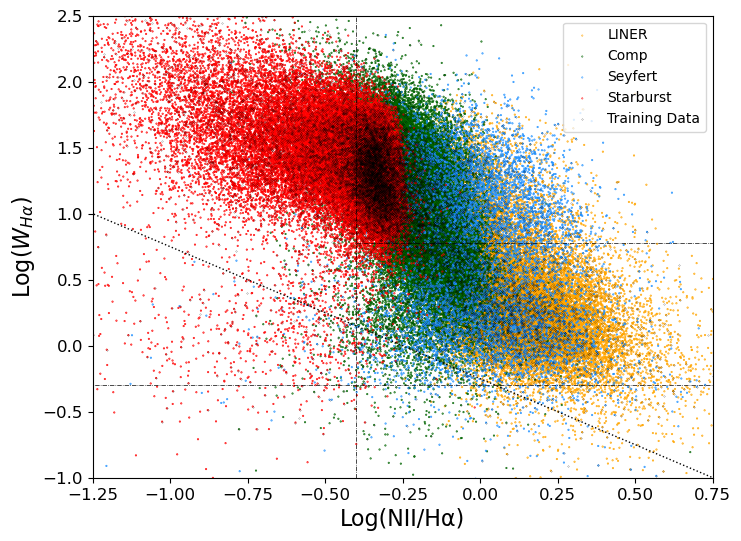

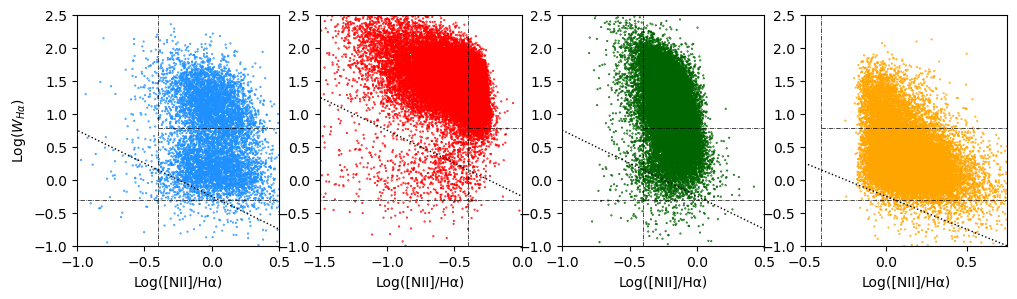

In [46]:
eqwx=df['NII/Hα']
eqwy=df['W_Hα']

fig, ax = plt.subplots(figsize=(8,6)) 

ax.scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(train['NII/Hα(T)'], train['W_Hα(T)'], c="black", s=0.02,label='Training Data') 
ax.axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax.hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax.hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
x = np.linspace(-3,3)
y=(-1*x)-0.25
ax.plot(x,y,':', color='black',lw=1) 
ax.legend()
ax.set_xlim(-1.25,0.75)
ax.set_ylim(-1,2.5)
ax.set_xlabel(r'Log(NII/Hα)',fontsize=16) 
ax.set_ylabel(r'Log($W_{Hα}$)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')
ax[0].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[0].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[0].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[0].plot(x,y,':', color='black',lw=1) 
ax[1].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[1].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[1].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[1].plot(x,y,':', color='black',lw=1) 
ax[2].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[2].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[2].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[2].plot(x,y,':', color='black',lw=1) 
ax[3].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[3].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[3].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[3].plot(x,y,':', color='black',lw=1) 
ax[0].set_xlim(-1,0.5)
ax[1].set_xlim(-1.5,0)
ax[2].set_xlim(-1,0.5)
ax[3].set_xlim(-0.5,0.75)
ax[0].set_ylim(-1,2.5)
ax[1].set_ylim(-1,2.5)
ax[2].set_ylim(-1,2.5)
ax[3].set_ylim(-1,2.5)
ax[0].set_xlabel(r'Log([NII]/Hα)')
ax[1].set_xlabel(r'Log([NII]/Hα)')
ax[2].set_xlabel(r'Log([NII]/Hα)')
ax[3].set_xlabel(r'Log([NII]/Hα)')
ax[0].set_ylabel(r'Log($W_{Hα}$)')
plt.show()

## Blue Diagram

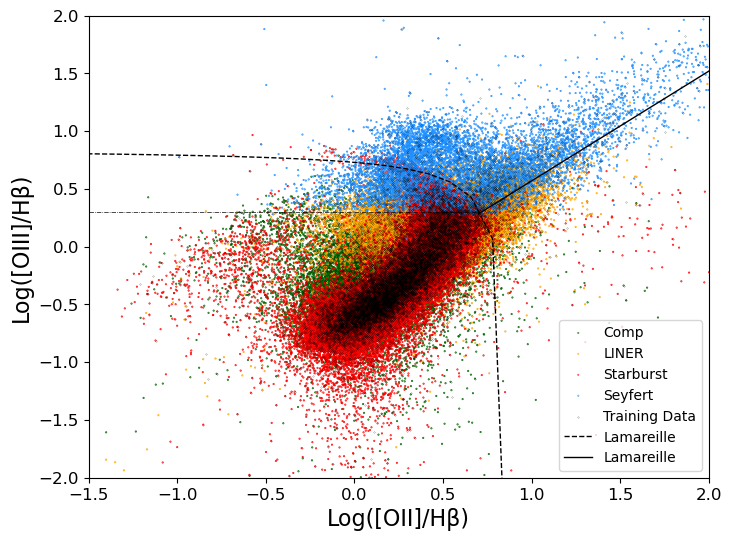

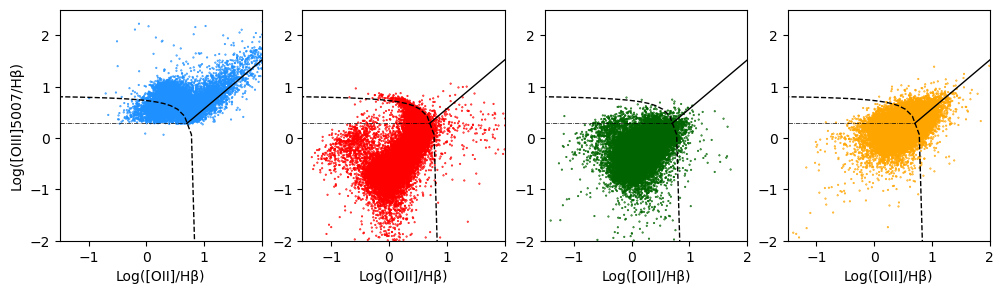

In [47]:
eqwx=df['OII/Hβ']
eqwy=df['OIII/Hβ']

x11 = np.linspace(-5,0.9)
y11 = 0.85 + (0.11/(x11-0.92))

x22 = np.linspace(0.7,4)
y22 = 0.95 * (x22-0.4)

x6 = np.linspace(-5,0.7)
y6 = 0.3+ (x6*0)

x7 = np.linspace(0.05, 1.07)
y7 = (-(x7 - 1.0)**2) - (0.1*x7) + 0.25
x8 = np.linspace(0.05 ,1.07)
y8 = ((x8 - 0.2)**2) - 0.6

fig, ax = plt.subplots(figsize=(8,6)) 
ax.scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.scatter(train['OII/Hβ(T)'], train['OIII/Hβ(T)'], c="black", s=0.02,label='Training Data') 
ax.plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax.plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax.hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)
ax.legend()
ax.set_xlim(-1.5,2)
ax.set_ylim(-2,2)
ax.set_xlabel(r'Log([OII]/Hβ)',fontsize=16) 
ax.set_ylabel(r'Log([OIII]/Hβ)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')

ax[0].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[0].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[0].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[1].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[1].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[1].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[2].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[2].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[2].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[3].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[3].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[3].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[0].set_xlim(-1.5,2)
ax[1].set_xlim(-1.5,2)
ax[2].set_xlim(-1.5,2)
ax[3].set_xlim(-1.5,2)
ax[0].set_ylim(-2,2.5)
ax[1].set_ylim(-2,2.5)
ax[2].set_ylim(-2,2.5)
ax[3].set_ylim(-2,2.5)
ax[0].set_xlabel(r'Log([OII]/Hβ)')
ax[1].set_xlabel(r'Log([OII]/Hβ)')
ax[2].set_xlabel(r'Log([OII]/Hβ)')
ax[3].set_xlabel(r'Log([OII]/Hβ)')
ax[0].set_ylabel(r'Log([OIII]5007/Hβ)')
plt.show()

# Photometry

## Color-Color Diagram

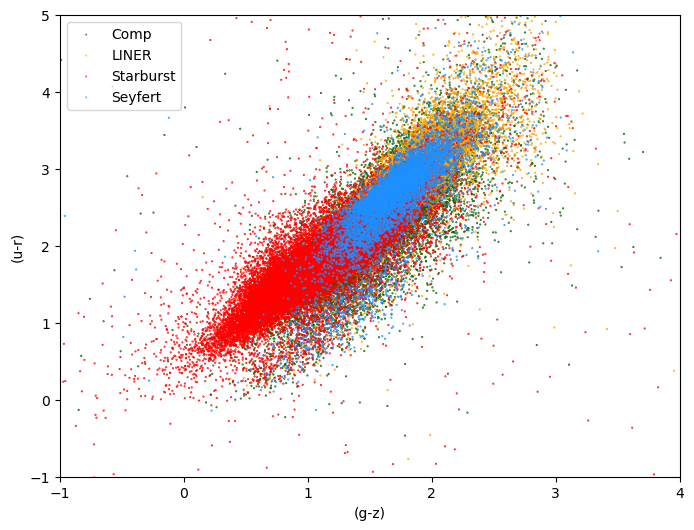

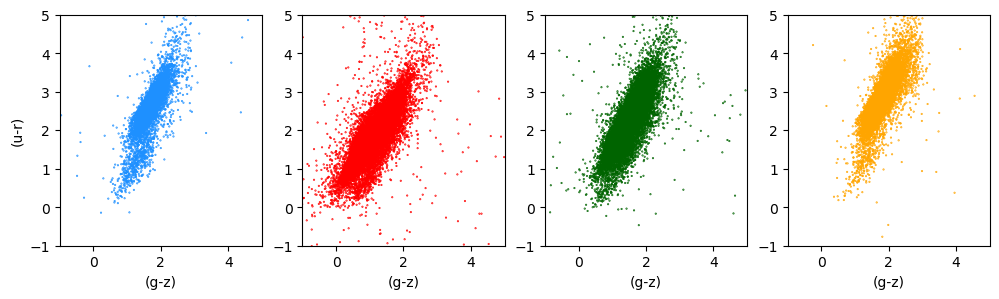

In [48]:
ejexgz=df['g-z']
ejeyur=df['u-r']

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(ejexgz,ejeyur, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(ejexgz,ejeyur, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(ejexgz,ejeyur, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(ejexgz,ejeyur, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.legend()
ax.set_xlim(-1,4)
ax.set_ylim(-1,5)
ax.set_xlabel(r'(g-z)') 
ax.set_ylabel(r'(u-r)')
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(ejexgz,ejeyur, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(ejexgz,ejeyur, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(ejexgz,ejeyur, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(ejexgz,ejeyur, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')

ax[0].set_xlim(-1,5)
ax[1].set_xlim(-1,5)
ax[2].set_xlim(-1,5)
ax[3].set_xlim(-1,5)
ax[0].set_ylim(-1,5)
ax[1].set_ylim(-1,5)
ax[2].set_ylim(-1,5)
ax[3].set_ylim(-1,5)
ax[0].set_xlabel(r'(g-z)') 
ax[1].set_xlabel(r'(g-z)') 
ax[2].set_xlabel(r'(g-z)') 
ax[3].set_xlabel(r'(g-z)') 
ax[0].set_ylabel(r'(u-r)')
plt.show()

## U-B Diagram

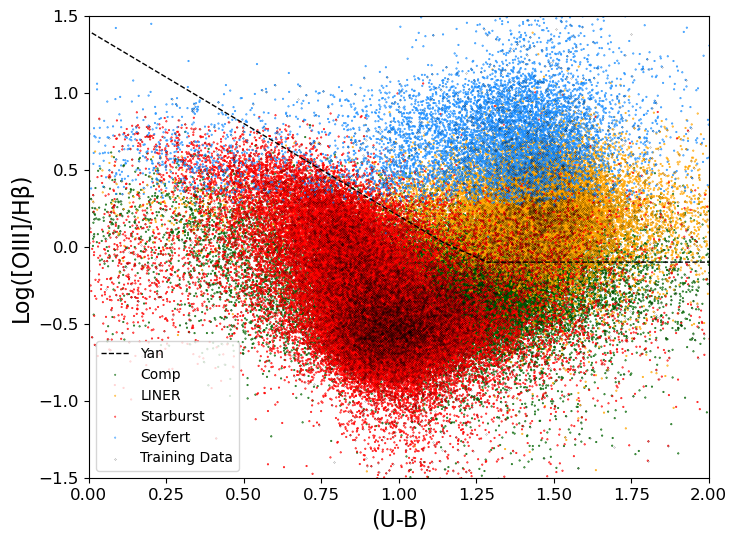

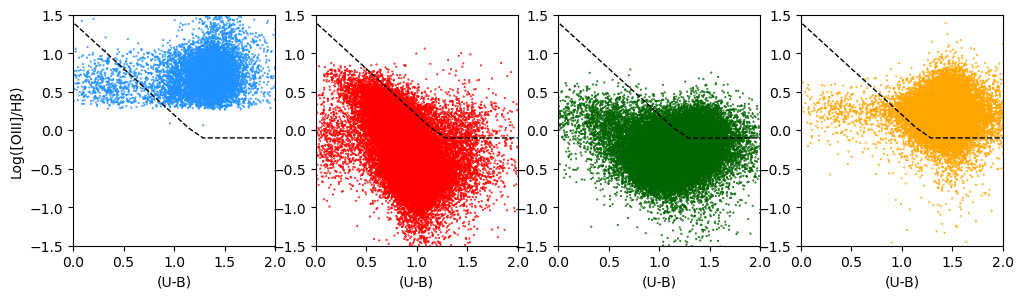

In [49]:
x1 = np.linspace(-2,5)
a=1.4-(1.2*x1)
a[a <= -0.1] = -0.1

ejexub=df['U-B']
ejeyub=df['OIII/Hβ']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x1,a,'--', color='black',lw=1, label='Yan') 
ax.scatter(ejexub,ejeyub, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(ejexub,ejeyub, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(ejexub,ejeyub, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(ejexub,ejeyub, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.scatter(train['U-B(T)'], train['OIII/Hβ(T)'], c="black", s=0.02,label='Training Data')
ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel(r'(U-B)',fontsize=16) 
ax.set_ylabel(r'Log([OIII]/Hβ)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(ejexub,ejeyub, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(ejexub,ejeyub, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(ejexub,ejeyub, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(ejexub,ejeyub, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')
ax[0].plot(x1,a,'--', color='black',lw=1) 
ax[1].plot(x1,a,'--', color='black',lw=1) 
ax[2].plot(x1,a,'--', color='black',lw=1) 
ax[3].plot(x1,a,'--', color='black',lw=1)
ax[0].set_xlim(0,2)
ax[1].set_xlim(0,2)
ax[2].set_xlim(0,2)
ax[3].set_xlim(0,2)
ax[0].set_ylim(-1.5,1.5)
ax[1].set_ylim(-1.5,1.5)
ax[2].set_ylim(-1.5,1.5)
ax[3].set_ylim(-1.5,1.5)
ax[0].set_xlabel(r'(U-B)') 
ax[1].set_xlabel(r'(U-B)') 
ax[2].set_xlabel(r'(U-B)') 
ax[3].set_xlabel(r'(U-B)') 
ax[0].set_ylabel(r'Log([OIII]/Hβ)')
plt.show()

# 3D Projection

In [51]:
df['Predicted Class']=df['Predicted Class'].replace({0:'Comp', 1:'Liner', 2:'Seyfert', 3:'Starburst'})
comp=df['Predicted Class']=='Comp'
lin=df['Predicted Class']=='LINER'
sf=df['Predicted Class']=='Seyfert'
sb=df['Predicted Class']=='Starburst'

## BPT vs. WHAN 

In [ ]:
%matplotlib qt
ejex1=df['W_Hα']
ejey1=df['NII/Hα']
ejez1=df['OIII/Hβ']
labels=df['Predicted Class']
df1 = pd.DataFrame(dict(x=ejex1, y=ejey1, z=ejez1, label=labels))

groups = df1.groupby('label')

color_palette = {'Comp': 'darkgreen', 'Liner': 'orange', 'Seyfert': 'dodgerblue', 'Starburst': 'red'}
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for name, group in groups:
    color = color_palette.get(name, 'gray')
    ax.plot(group.x, group.y, group.z, marker='*', linestyle='', ms=1, label=name, color=color)
    
ax.scatter(train['W_Hα(T)'],train['NII/Hα(T)'], train['OIII/Hβ(T)'], c="black",s=0.02,label='Training Data') 
ax.set_xlim(-1,3)
ax.set_ylim(-2,1)
ax.set_zlim(-1.5,1.5)
ax.set_xlabel(r'Log($W_{Hα}$)') 
ax.set_ylabel(r'Log(NII/Hα)')
ax.set_zlabel(r'Log([OIII]5007/Hβ)')
ax.legend()
plt.show()

# Blue vs. U-B

In [ ]:
%matplotlib qt
ejex1=df['U-B']
ejey1=df['OII/Hβ']
ejez1=df['OIII/Hβ']
labels=df['Predicted Class']
df1 = pd.DataFrame(dict(x=ejex1, y=ejey1, z=ejez1, label=labels))

groups = df1.groupby('label')

color_palette = {'Comp': 'darkgreen', 'Liner': 'orange', 'Seyfert': 'dodgerblue', 'Starburst': 'red'}
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for name, group in groups:
    color = color_palette.get(name, 'gray')
    ax.plot(group.x, group.y, group.z, marker='*', linestyle='', ms=1, label=name, color=color)
    
ax.scatter(train['U-B(T)'],train['OII/Hβ(T)'], train['OIII/Hβ(T)'], c="black",s=0.02,label='Training Data') 
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-1,2)
ax.set_zlim(-1.5,2)
ax.set_xlabel(r'(U-B)') 
ax.set_ylabel(r'Log(OII/Hβ)')
ax.set_zlabel(r'Log([OIII]5007/Hβ)')
ax.legend()
plt.show()

## Color - Color

In [ ]:
%matplotlib qt
ejex=df['g-z']
ejey=df['OIII/Hβ']
ejez=df['u-r']
labels=df['Predicted Class']
df4 = pd.DataFrame(dict(x=ejex, y=ejey, z=ejez, label=labels))

groups = df4.groupby('label')

color_palette = {'Comp': 'darkgreen', 'Liner': 'orange', 'Seyfert': 'dodgerblue', 'Starburst': 'red'}
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for name, group in groups:
    color = color_palette.get(name, 'gray')
    ax.plot(group.x, group.y, group.z, marker='*', linestyle='', ms=1, label=name, color=color)

ax.scatter(train['g-z(T)'], train['OIII/Hβ(T)'], train['u-r(T)'], c="black",s=0.02,label='Training Data')
ax.set_xlim(0,2.5)
ax.set_ylim(-2,2)
ax.set_zlim(0,4)
ax.set_xlabel(r'(g-z)') 
ax.set_zlabel(r'(u-r))')
ax.set_ylabel(r'Log([OIII]5007/Hβ)')
ax.legend()
plt.show()

# Statistics 

In [ ]:
fig=px.box(df, x="U-B", y="Predicted Class", points="all")
fig.update_layout(xaxis_title="(U-B)", yaxis_title="Log([NII]/Hα)")

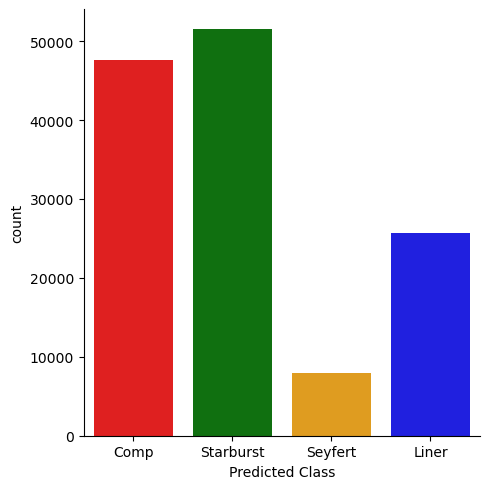

In [53]:
%matplotlib inline
w=sns.factorplot('Predicted Class',data=df,kind="count")
custom_palette = ["red","green","orange","blue"]
w=sns.set_palette(custom_palette)

In [ ]:
sns.heatmap(df.corr(), annot=True) and plt.show()